# Search Engines Market Analysis

In [1]:
%matplotlib inline

import sys
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt

from itertools import product
from dateutil.parser import parse
from datetime import date, timedelta

In [2]:
# Plot
plt.style.use('bmh')
mlp.rcParams['figure.figsize'] = (16, 8)

In [3]:
%%capture
# R
from rpy2.robjects import r, pandas2ri as pd2
pd2.activate()
sys.path.extend(['./forecast-master', './forecast-master/forecast'])
from forecast import forecast, stl, stldf, bind

## Data Reading

Считываем датасет `my_raw_data.csv`, полученный в `fetch.ipynb`.

* `date` - дата по дням с 2014-01-01 до 2017-09-28 включительно
* `se` - поисковая система, либо yandex либо search
* `browser` - браузер, 5 типов
* `hits` - количество хитов

In [4]:
df = pd.read_csv('my_raw_data.csv')
df.isnull().values.any()  # Check if df has nan values.

False

In [5]:
df.head()

,date,se,browser,hits
0,2014-01-01,search,chrome,44778823
1,2014-01-01,search,firefox,16417487
2,2014-01-01,search,msie,7056536
3,2014-01-01,search,opera,12246238
4,2014-01-01,search,yabrowser,8845385


In [6]:
df.tail()

,date,se,browser,hits
13665,2017-09-28,yandex,chrome,10982236
13666,2017-09-28,yandex,firefox,5137327
13667,2017-09-28,yandex,msie,2133180
13668,2017-09-28,yandex,opera,3448505
13669,2017-09-28,yandex,yabrowser,11082319


In [7]:
FIRST_DAY, LAST_DAY = parse(df.date[0]), parse(df.date.iloc[-1])
FIRST_DAY, LAST_DAY

(datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2017, 9, 28, 0, 0))

In [8]:
df.describe()

,hits
count,1.367000e+04
mean,1.378557e+07
std,1.192883e+07
min,0.000000e+00
25%,6.854102e+06
50%,1.146197e+07
75%,1.553245e+07
max,6.667708e+07


In [9]:
SES, BROWSERS = np.unique(df['se']).tolist(), np.unique(df['browser']).tolist()
SES, BROWSERS

(['search', 'yandex'], ['chrome', 'firefox', 'msie', 'opera', 'yabrowser'])

## Data Prerocessing

Устраняем аномалии в данных.

### Дополним недостающие данные

Заметим, что дней с первого до последнего рассматриваемого дня:

In [10]:
(LAST_DAY - FIRST_DAY).days + 1

1367

А в датасета на каждую из 10 пар se, brower есть:

In [11]:
df.groupby(['se', 'browser']).size()

se      browser  
search  chrome       1367
        firefox      1367
        msie         1367
        opera        1367
        yabrowser    1367
yandex  chrome       1367
        firefox      1367
        msie         1367
        opera        1367
        yabrowser    1367
dtype: int64

Пропущенные значение - 4 дня от 2014-12-28 до 2014-12-31, пока восстановим их нулями.  

#NOTE: в новом датасет такой проблемы нет

In [12]:
# missing_dates = ['2014-12-28', '2014-12-29', '2014-12-30', '2014-12-31']
# for date, se, browser in product(missing_dates, SES, BROWSERS):
#     df = df.append({'date': date, 'se': se, 'browser': browser, 'hits': 0.0}, ignore_index=True)

df.date = df.date.astype('datetime64[ns]')
df.sort_values(df.columns.tolist(), inplace=True)
df.reset_index(drop=True, inplace=True)
df.dtypes

date       datetime64[ns]
se                 object
browser            object
hits                int64
dtype: object

Продолжим разбираться с данными.

In [13]:
def plot_pivot(df_to_plot, columns, *, title=None):
    data_args = {'index': 'date', 'values': 'hits', 
                 'columns': columns, 'aggfunc': np.sum}
    plot_args = {'title': title or f'{columns} pivot'}
    df_to_plot.pivot_table(**data_args).plot(**plot_args)


def plot_fix(fix, df_to_plot, columns):
    plot_pivot(df_to_plot, columns, title=f'before {fix.__name__}')
    plot_pivot(fix(df_to_plot), columns, title=f'after {fix.__name__}')

### Разрез `se`

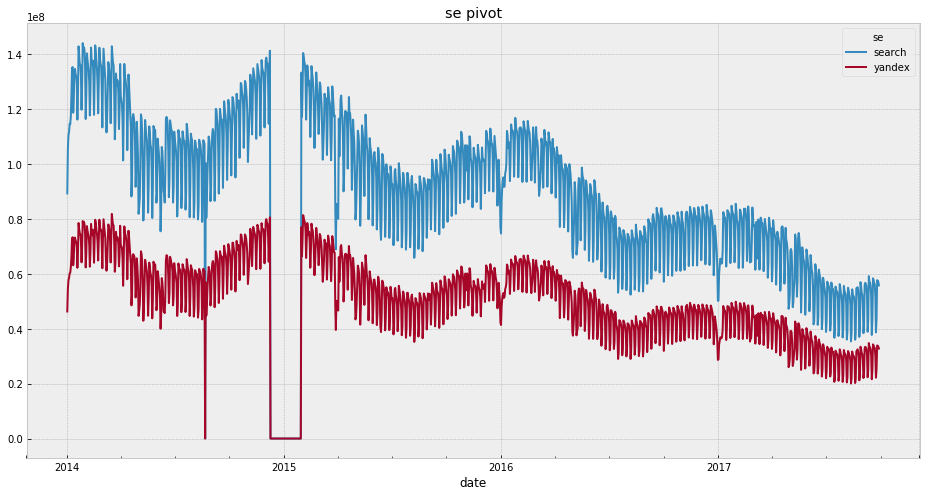

In [14]:
plot_pivot(df, 'se')

Что можно заметить?  
Во-первых, первые пару дней в январе 2014 аномально маленькие (хоть это и новогодние праздники, но в других годах падение не такое существенное). Посмотрим поближе.

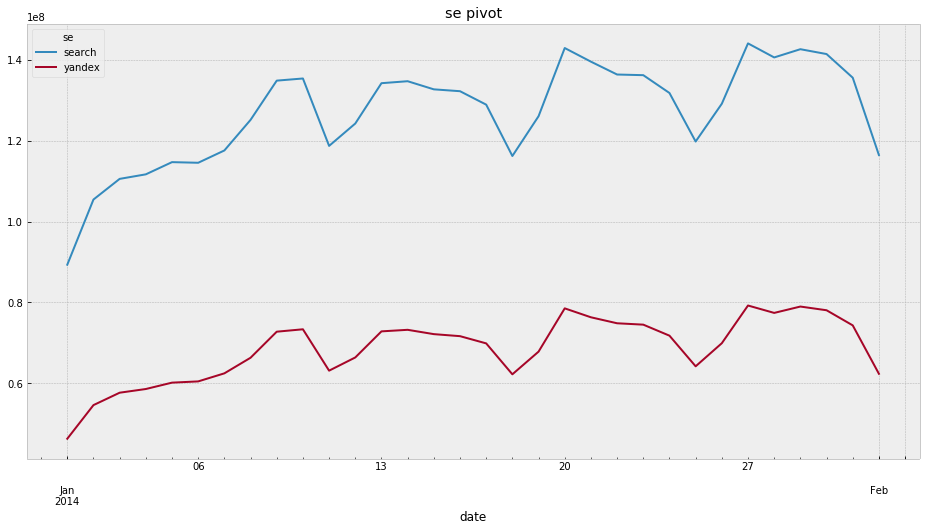

In [15]:
plot_pivot(df[df.date <= '2014-02-01'], 'se')

Видно, что можем отрезать префикм до 9-го числа.

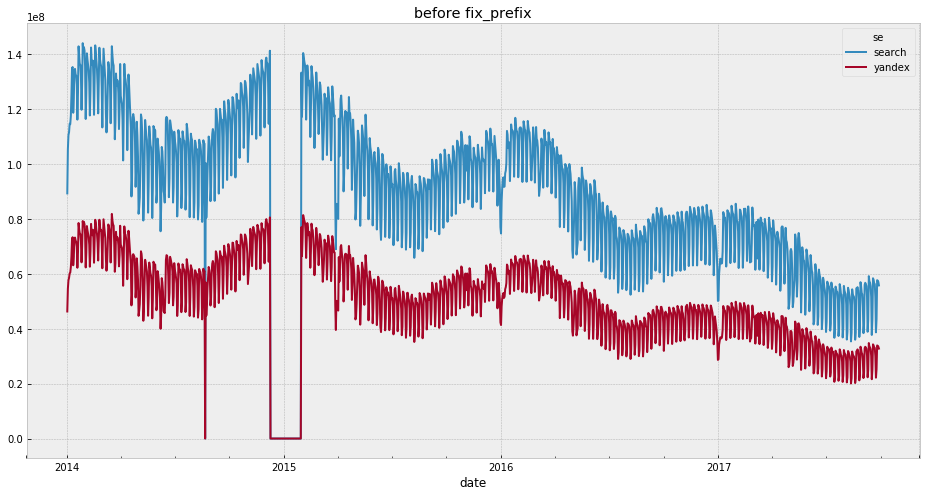

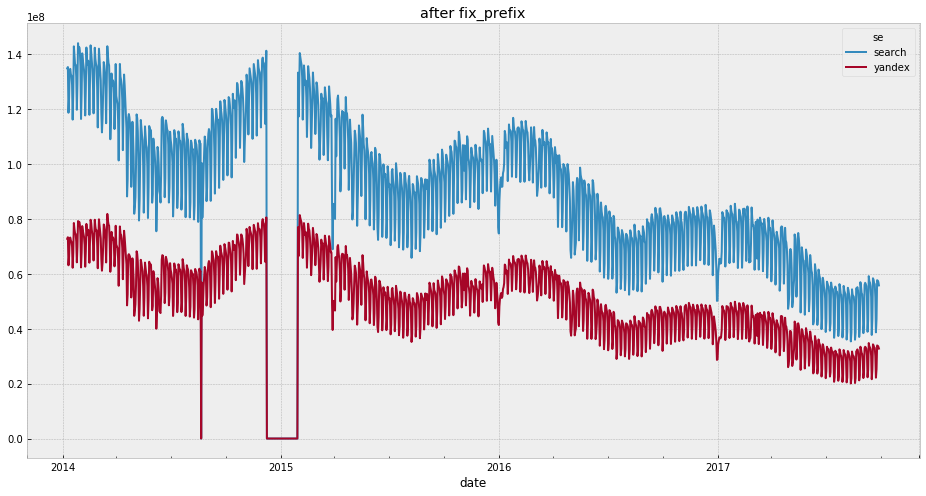

In [16]:
def fix_prefix(df): return df[df.date >= '2014-01-09']
plot_fix(fix_prefix, df, 'se')

In [17]:
df = fix_prefix(df)

Теперь посмотрим на аномальное низкие показатели в районе 2014-09, новый год 15-го и в районе 2015-03-15.

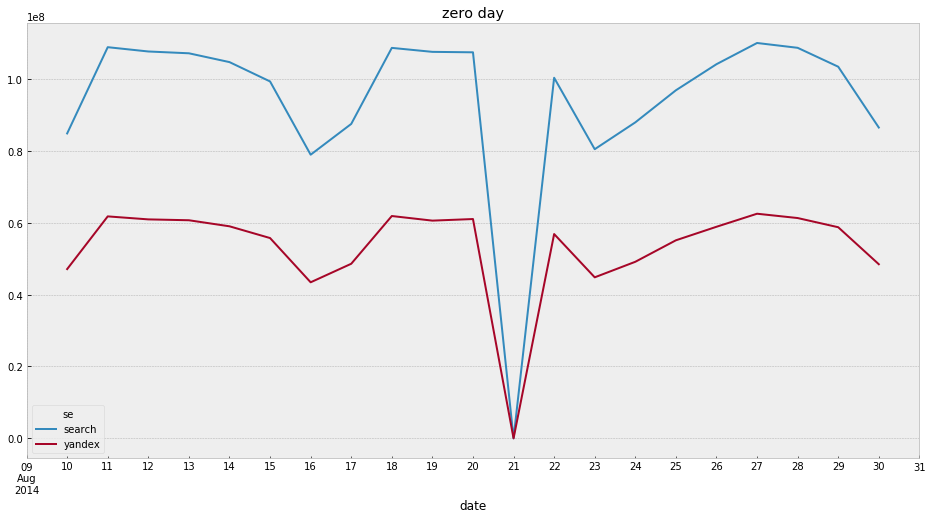

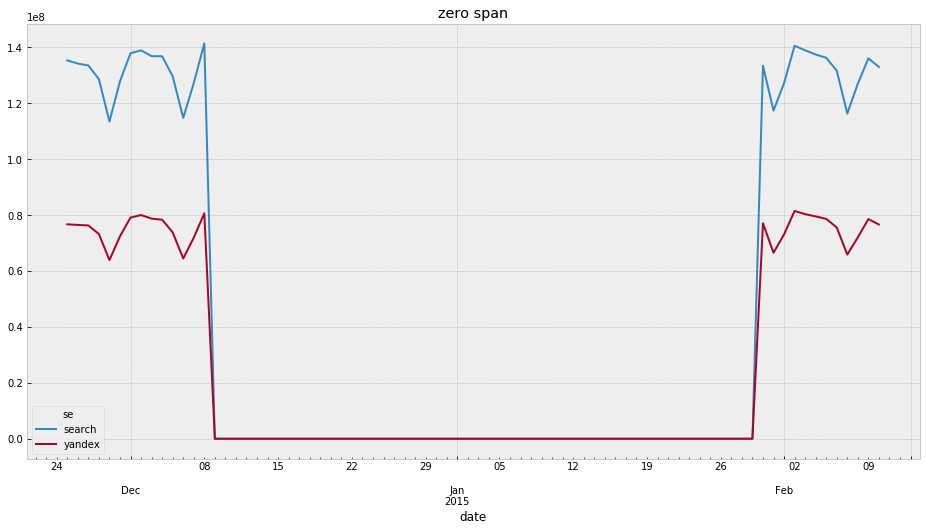

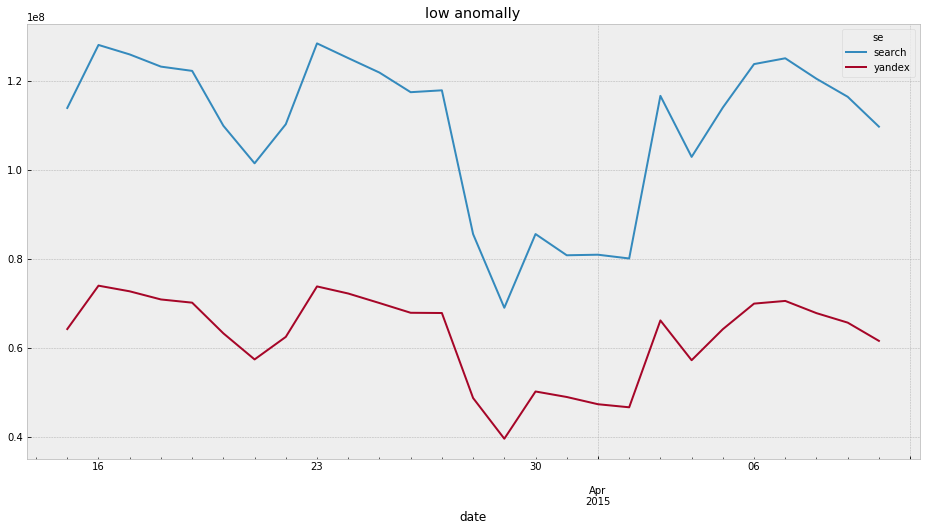

In [18]:
plot_pivot(df[('2014-08-10' <= df.date) & (df.date <= '2014-08-30')], 'se', title='zero day')
plot_pivot(df[('2014-11-25' <= df.date) & (df.date <= '2015-02-10')], 'se', title='zero span')
plot_pivot(df[('2015-03-15' <= df.date) & (df.date <= '2015-04-10')], 'se', title='low anomally')

Зафиксируем промежутки (значение подберем эмпирически - так быстрее).

In [19]:
ZDAY = '2014-08-21'
ZSPAN = '2014-12-09', '2015-01-29'
LSPAN = '2015-03-27', '2015-04-04'

Напишем фикс.  
Для нулевого дня возьмем среднее ближайших, для нулевого промежутка - перенесем и отскалируем со следующего года.  
Для спайка перенесем со следующей недели.

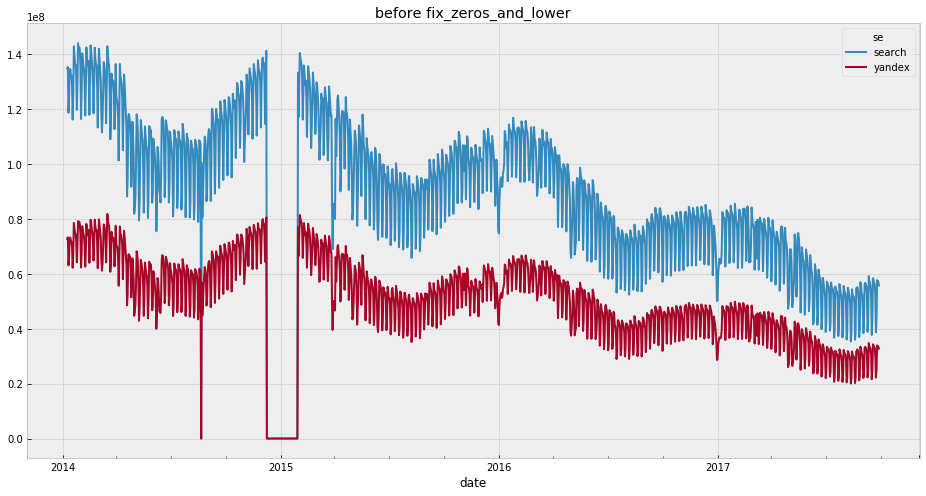

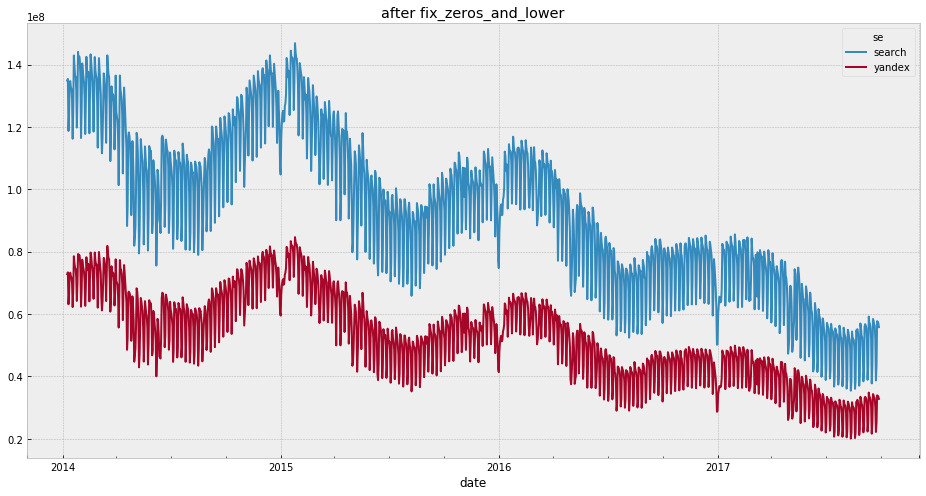

In [20]:
def fix_zeros_and_lower(df):
    df = df.copy()
    zday = parse(ZDAY)
    zleft, zright = parse(ZSPAN[0]), parse(ZSPAN[1])
    lleft, lright = parse(LSPAN[0]), parse(LSPAN[1])
    
    def past(d, days=1): return d - timedelta(days=days)
    def seek(d, days=1): return d + timedelta(days=days)
    
    for se, browser in product(SES, BROWSERS):
        cond = (df.se == se) & (df.browser == browser)
        
        prev_day = df.loc[cond & (df.date == past(zday)), 'hits'].values[0]
        next_day = df.loc[cond & (df.date == seek(zday)), 'hits'].values[0]
        df.loc[cond & (df.date == zday), 'hits'] = (prev_day + next_day) // 2
        
        nleft, nright = seek(zleft, days=365), seek(zright, days=365)
        zleft_val = df.loc[cond & (df.date == past(zleft)), 'hits'].values[0]
        nleft_val = df.loc[cond & (df.date == past(nleft)), 'hits'].values[0]
        nspan = df.loc[cond & (nleft <= df.date) & (df.date <= nright), 'hits'].values
        df.loc[cond & (zleft <= df.date) & (df.date <= zright), 'hits'] = nspan - nleft_val + zleft_val
        
        nvalues = df.loc[cond & (seek(lleft, days=7) <= df.date) & (df.date <= seek(lright, days=7)), 'hits']
        df.loc[cond & (lleft <= df.date) & (df.date <= lright), 'hits'] = nvalues.values

    return df


plot_fix(fix_zeros_and_lower, df, 'se')

In [21]:
old_df = df
df = fix_zeros_and_lower(df)

### Разрез `browser`

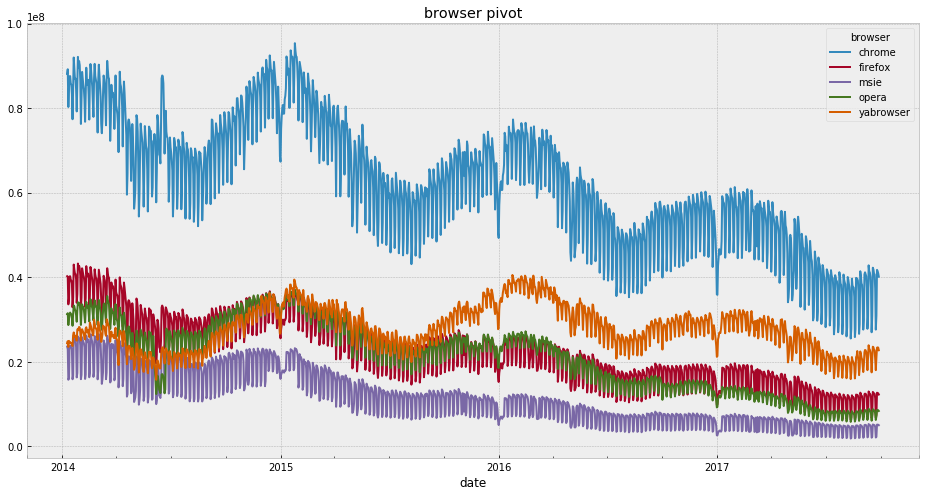

In [22]:
plot_pivot(df, 'browser')

Все ок, кроме спайка у хрома и оперы в серединке между 2014 и 2015. Посмотрим поближе.

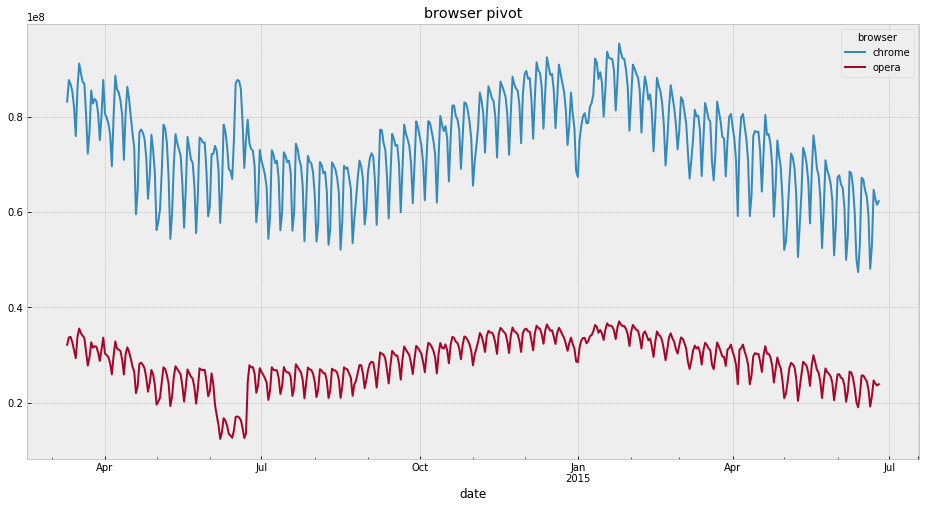

In [23]:
span = ('2014-03-10' <= df.date) & (df.date <= '2015-06-25')
cond = span & ((df.browser == 'opera') | (df.browser == 'chrome'))
plot_pivot(df[cond], 'browser')

Напишем фикс, значения с последующих дней (тут нам не потребовалась даже скалировать значения, так они одного порядка).

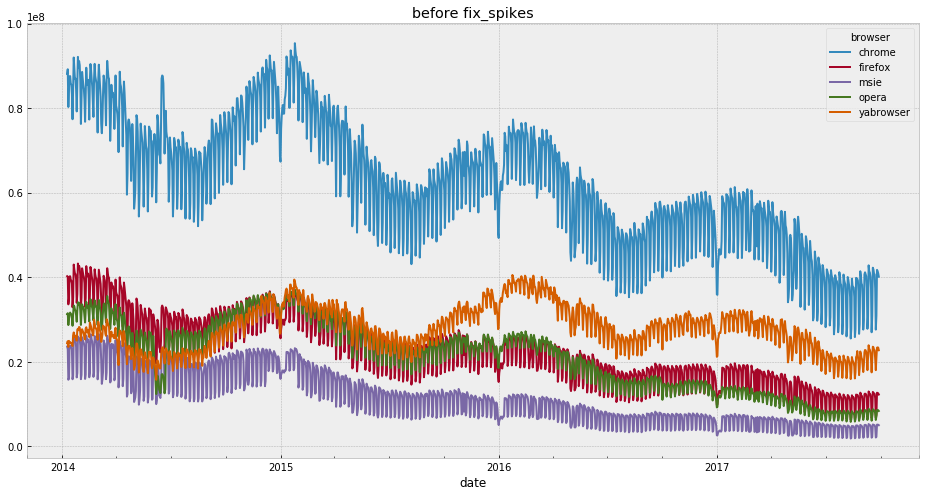

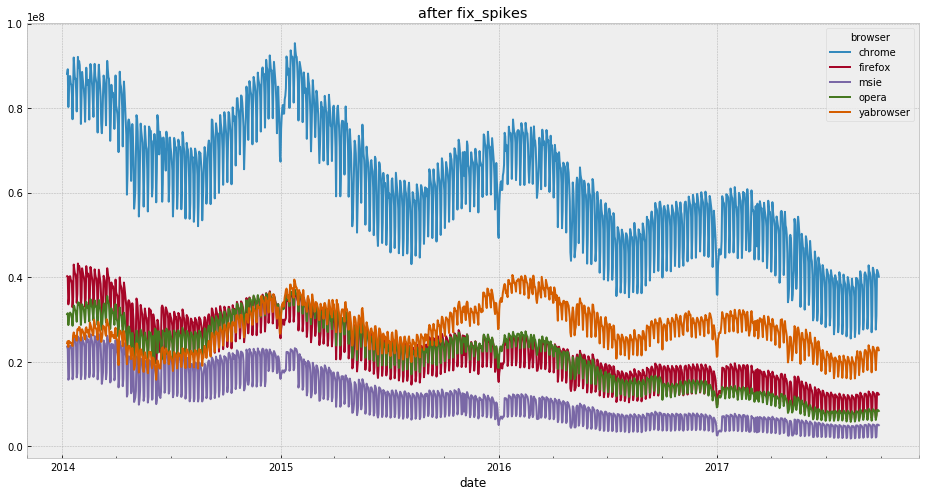

In [24]:
SSPAN = '2014-06-13', '2014-06-23'
OSPAN = '2014-06-05', '2014-06-23'


def fix_spikes(df):
    df = df.copy()
    sleft, sright = parse(SSPAN[0]), parse(SSPAN[1])
    oleft, oright = parse(OSPAN[0]), parse(OSPAN[1])
    
    def past(d, days=1): return d - timedelta(days=days)
    def seek(d, days=1): return d + timedelta(days=days)
    
    for se in SES:
        cond = (df.se == se) & (df.browser == 'chrome')
        days = (sright - sleft).days + 1
        nvalues = df.loc[cond & (seek(sright, days=1) <= df.date) & (df.date <= seek(sright, days=days)), 'hits']
        df.loc[cond & (sleft <= df.date) & (df.date <= sright), 'hits'] = nvalues.values
    
    for se in SES:
        cond = (df.se == se) & (df.browser == 'opera')
        days = (oright - oleft).days + 1
        nvalues = df.loc[cond & (seek(oright, days=1) <= df.date) & (df.date <= seek(oright, days=days)), 'hits']
        df.loc[cond & (oleft <= df.date) & (df.date <= oright), 'hits'] = nvalues.values
    
    return df


plot_fix(fix_spikes, df, 'browser')

Good. Еще раз посмотрим на оба среза.

In [25]:
df = fix_spikes(df)

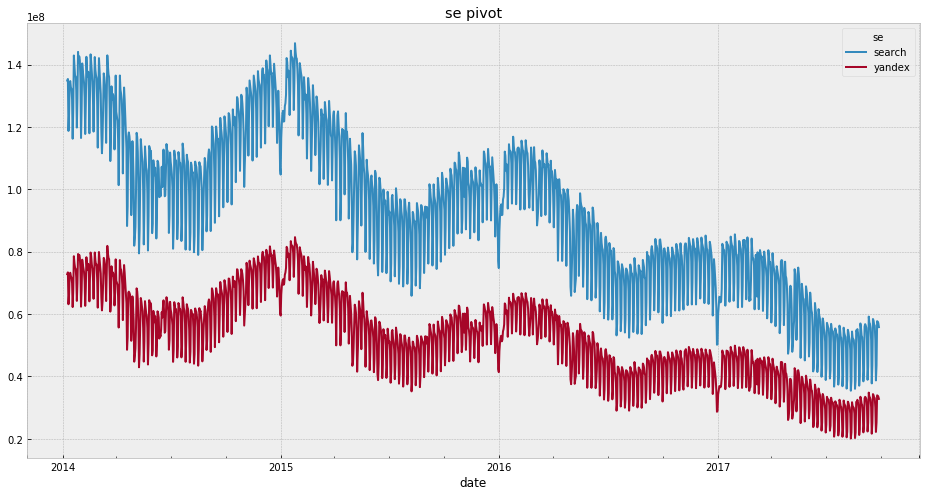

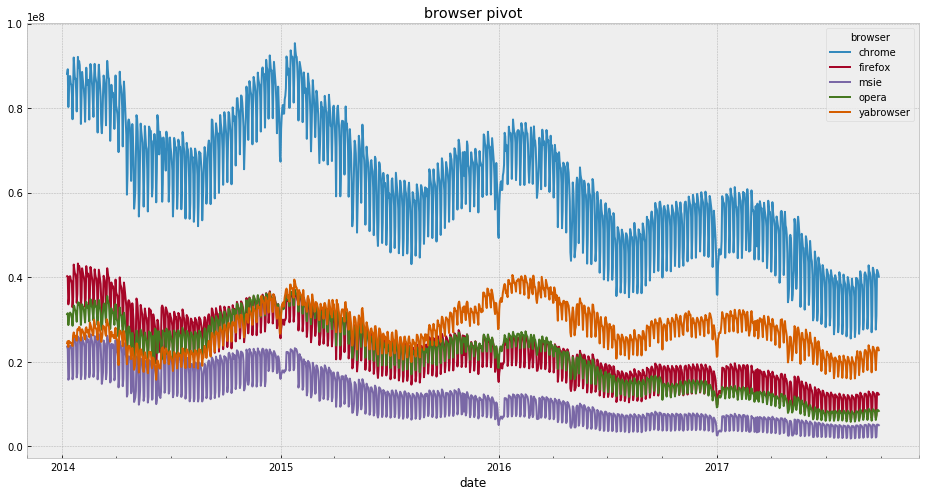

In [26]:
plot_pivot(df, 'se')
plot_pivot(df, 'browser')

Все ок. Остальные всплески очень похожи на сезонные явления.

In [27]:
old_df['hits_fixed'] = np.round(df.hits)
df = old_df

## STL

In [28]:
bind(pd.DataFrame, stldf)
bind(pd.Series, stl, forecast)

new_columns = ['hits_week_trend', 'hits_week_seasonal', 'hits_year_trend', 'hits_year_seasonal']
for column in new_columns:
    df[column] = np.zeros(len(df))

for se, browser in product(SES, BROWSERS):
    cond = (df.se == se) & (df.browser == browser)
    
    ts = pd.Series(df.loc[cond, 'hits_fixed'].tolist(), index=df.loc[cond, 'date'])
    res = ts.stl(frequency=7, method='arima')
    trend = res.iloc[:, 1].as_matrix()
    seasonal = (res.iloc[:, 0] + res.iloc[:, 1]).as_matrix()
    df.loc[cond, 'hits_week_trend'] = np.round(trend)
    df.loc[cond, 'hits_week_seasonal'] = np.round(seasonal)
    
    ts = pd.Series(trend, index=df.loc[cond, 'date'])
    res = ts.stl(frequency=365, method='arima')
    trend = res.iloc[:, 1].as_matrix()
    seasonal = (res.iloc[:, 0] + res.iloc[:, 1]).as_matrix()
    df.loc[cond, 'hits_year_trend'] = np.round(trend)
    df.loc[cond, 'hits_year_seasonal'] = np.round(seasonal)

Посмотрим на снятие недельной сезонности:

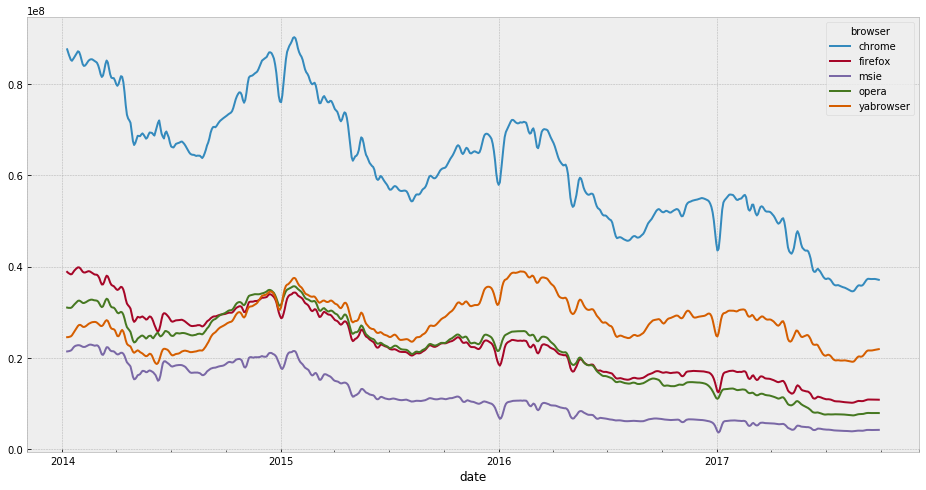

In [29]:
df.pivot_table(index='date', values='hits_week_trend', columns='browser', aggfunc=np.sum).plot();

Годовой:

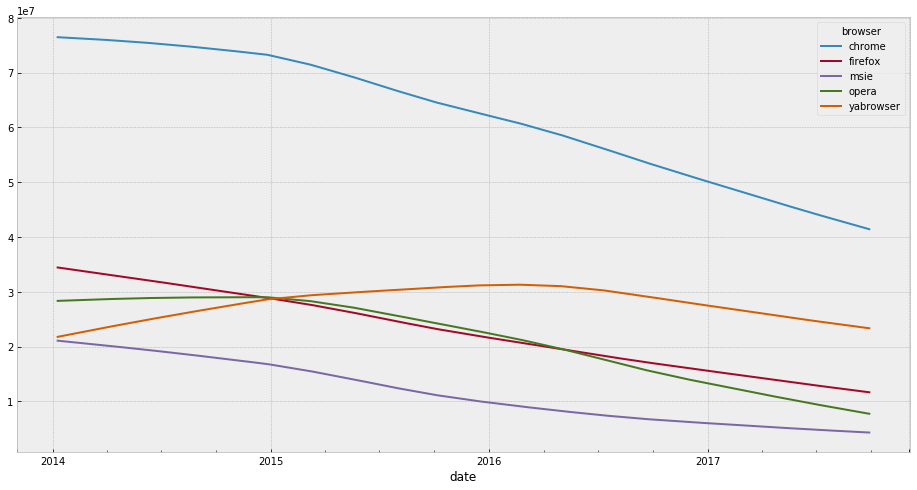

In [30]:
df.pivot_table(index='date', values='hits_year_trend', columns='browser', aggfunc=np.sum).plot();

Сохраним результат в csv.

In [31]:
df.to_csv('clean_data.csv', index=False)